In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, cavi_lib
import vb_lib.structure_optimization_lib as s_optim_lib
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul

import paragami
import vittles

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib
from bnpmodeling_runjingdev.sensitivity_lib import get_jac_hvp_fun

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
autograd_results = np.load('./tmp.npz')

In [3]:
import numpy as onp
onp.random.seed(53453)

# Draw data

In [4]:
n_obs = 5
n_loci = 10
n_pop = 4

In [5]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

Generating datapoints  0  to  5


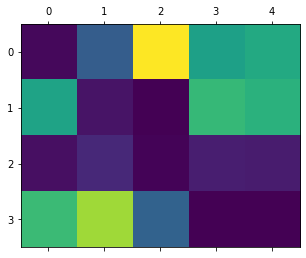

In [6]:
plt.matshow(true_ind_admix_propn.T)

In [7]:
g_obs = np.array(g_obs)

In [8]:
assert np.all(g_obs  == autograd_results['g_obs'])

# Get prior

In [9]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


# Get VB params 

In [10]:
k_approx = 8

In [11]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [12]:
use_logitnormal_sticks = True

_, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (10, 8, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (5, 7) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (5, 7) (lb=0.0001, ub=inf)


In [13]:
vb_params_free = autograd_results['vb_params_free']
vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)

assert np.all(vb_params_paragami.flatten(vb_params_dict, free = False) == \
              autograd_results['vb_params_flattened'])

# Define objective

In [14]:
stru_objective = s_optim_lib.StructureObjective(g_obs, 
                                                 vb_params_paragami,
                                                 prior_params_dict, 
                                                 gh_loc, gh_weights)

compiling objective ... 
done. Elasped: 80.966


# Check gradients are the same as autograd

In [15]:
assert np.abs(stru_objective.f(vb_params_free) - \
              autograd_results['kl']) < 1e-8

In [16]:
assert np.abs(stru_objective.grad(vb_params_free) - \
              autograd_results['kl_grad']).max() < 1e-8

In [17]:
kl_hess = autograd_results['kl_hess']

for i in range(kl_hess.shape[0]): 
    
    e_i = onp.zeros(kl_hess.shape[0])
    e_i[i] = 1
    
    hvp1 = stru_objective.hvp(vb_params_free, e_i)
    hvp2 = np.dot(kl_hess, e_i)
    
    assert np.abs(hvp1 - hvp2).max() < 1e-8

In [18]:
hvp2

DeviceArray([-2.17205245e-03,  4.17055880e-03, -1.46833920e-03,
              2.91553673e-03, -2.42525172e-03,  4.31047878e-03,
             -1.93001950e-03,  3.90341296e-03, -4.88034494e-04,
              6.49088324e-04, -2.51817819e-04,  3.82583476e-04,
              7.98699434e-04, -1.90597864e-03,  6.40353224e-03,
             -1.14175356e-02, -8.96375390e-04,  1.69527786e-03,
             -8.41802264e-04,  1.28967311e-03, -2.94652043e-04,
              5.67827951e-04, -7.49482541e-04,  1.02461811e-03,
             -2.22140296e-04,  3.03516777e-04, -1.48196870e-04,
              1.91381047e-04,  2.40575642e-04, -2.62602153e-04,
              3.93586429e-04, -7.04055604e-04,  2.45486209e-04,
              2.18761277e-03, -4.67251117e-05,  3.20720271e-04,
             -1.09498449e-03,  1.96236690e-03,  5.34217232e-05,
              4.06736312e-04, -1.96029998e-05,  5.66116084e-05,
             -5.29356261e-05,  1.80431089e-04,  5.98506838e-05,
             -2.26137791e-04,  1.5136179

In [19]:
hvp1

DeviceArray([-2.17205245e-03,  4.17055880e-03, -1.46833920e-03,
              2.91553673e-03, -2.42525172e-03,  4.31047878e-03,
             -1.93001950e-03,  3.90341296e-03, -4.88034494e-04,
              6.49088324e-04, -2.51817819e-04,  3.82583476e-04,
              7.98699434e-04, -1.90597864e-03,  6.40353224e-03,
             -1.14175356e-02, -8.96375390e-04,  1.69527786e-03,
             -8.41802264e-04,  1.28967311e-03, -2.94652043e-04,
              5.67827951e-04, -7.49482541e-04,  1.02461811e-03,
             -2.22140296e-04,  3.03516777e-04, -1.48196870e-04,
              1.91381047e-04,  2.40575642e-04, -2.62602153e-04,
              3.93586429e-04, -7.04055604e-04,  2.45486209e-04,
              2.18761277e-03, -4.67251117e-05,  3.20720271e-04,
             -1.09498449e-03,  1.96236690e-03,  5.34217232e-05,
              4.06736312e-04, -1.96029998e-05,  5.66116084e-05,
             -5.29356261e-05,  1.80431089e-04,  5.98506838e-05,
             -2.26137791e-04,  1.5136179

In [20]:
import inspect
lines = inspect.getsource(structure_model_lib.get_e_loglik)
print(lines)

def get_e_loglik(g_obs, e_log_pop_freq, e_log_1m_pop_freq, \
                    e_log_sticks, e_log_1m_sticks,
                    detach_ez):


    e_log_cluster_probs = \
        modeling_lib.get_e_log_cluster_probabilities_from_e_log_stick(
                            e_log_sticks, e_log_1m_sticks)
    
    body_fun = lambda val, x : get_e_loglik_l(x[0], x[1], x[2],
                                             e_log_cluster_probs,
                                             detach_ez) + val
    
    scan_fun = lambda val, x : (body_fun(val, x), None)
    
    return jax.lax.scan(scan_fun,
                        init = 0.,
                        xs = (g_obs.transpose((1, 0, 2)),
                              e_log_pop_freq, 
                              e_log_1m_pop_freq))[0]

